<a href="https://colab.research.google.com/github/jjeswinjacob/NLP_Lab_Solutions/blob/master/quoraFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


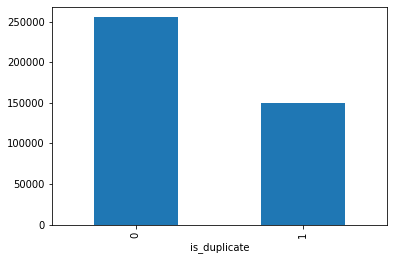

In [5]:
import pandas as pd # data manipulation and analysis
df = pd.read_csv('train.csv') # Returns a dataframe
df.dropna(axis=0, inplace=True) # axis = 0 drops Rows with missing values and changes values in the same dataframe
df.groupby("is_duplicate")['id'].count().plot.bar()
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True) # Drop specified labels

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
from string import punctuation

**Text Preprocessing**

In [7]:
def clean(text):
    # Clean the text
    text = re.sub(" what's ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
  
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()

    # Lemmatizing Text
    lemmatizer = WordNetLemmatizer() 
    text = ''.join([lemmatizer.lemmatize(c) for c in text])
    
    return text
    
df['question1'] = df['question1'].apply(clean) # axis = 0 by default and to apply clean on every row in given dataframe
df['question2'] = df['question2'].apply(clean)

Regularization Parameters Legend:

* Gamma - Tree Complexity Parameter - Minimum loss reduction allowed for a split to occur. If Gain - Gamma = +ve, we keep node, else discard. So, we don't prune as long as we have a positive gain.

* Alpha - L1 (Lasso) regularization on leaf weights, larger values mean more regularization - Larger values of Alpha helps us do away with useless features. Encourages values to go to zero. Reduces the amount each leaf contributes in output value

* Lambda - L2 (Ridge) regularization on leaf weights - Introduces Bias to reduce Variance - When lambda = 0, we ignore this regularization. 

* scale_pos_weight set to ratio of negative class entities to positive class entities

**Model 1: BOW -> XGBoost**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# Countvectorizer lowercases all words by default
count_vect = CountVectorizer(analyzer='word')
# The fit method learns the vocabulary of all tokens in the documents
count_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)
labels = df['is_duplicate'].values

import scipy
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

!pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.679638
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.70193
[2]	validation_0-aucpr:0.71836
[3]	validation_0-aucpr:0.729554
[4]	validation_0-aucpr:0.735555
[5]	validation_0-aucpr:0.74137
[6]	validation_0-aucpr:0.745527
[7]	validation_0-aucpr:0.750151
[8]	validation_0-aucpr:0.754121
[9]	validation_0-aucpr:0.758675
[10]	validation_0-aucpr:0.762979
[11]	validation_0-aucpr:0.767085
[12]	validation_0-aucpr:0.770508
[13]	validation_0-aucpr:0.772949
[14]	validation_0-aucpr:0.776118
[15]	validation_0-aucpr:0.778538
[16]	validation_0-aucpr:0.780527
[17]	validation_0-aucpr:0.782577
[18]	validation_0-aucpr:0.784386
[19]	validation_0-aucpr:0.786479
[20]	validation_0-aucpr:0.787911
[21]	validation_0-aucpr:0.788909
[22]	validation_0-aucpr:0.790754
[23]	validation_0-aucpr:0.792262
[24]	validation_0-aucpr:0.793442
[25]	validation_0-aucpr:0.794316
[26]	validation_0-aucpr:0.795235
[27]	validation_0-aucpr:0.79598
[28]	validation_0-aucpr:

Legend:
* Precision is out of all predictions of one class, how many are right. TP/ (TP + FP) eg. Out of all duplicate prediction, how many are actually duplicate

* Recall is out of all entities of one class, how many are correctly predicted. TP/ (TP + FN) eg. Out of all duplicate questions in dataset, how many are predicted correctly

* f1-score = 2(Precision * Recall)/ (Precision + Recall) - Harmonic Mean of Precision and Recall
 f1-score = TP/ (TP + (FP + FN)/ 2)

* Macro average is unweighted average of probabilities in both class.

* Support is the number of actual occurrences of the class in the specified dataset. 

* Weighted average gives the support-weighted mean per label.

**Model 2: TFIDF + XGBoost**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word')
tfidf_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18)

xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.678644
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.702687
[2]	validation_0-aucpr:0.719437
[3]	validation_0-aucpr:0.731345
[4]	validation_0-aucpr:0.74073
[5]	validation_0-aucpr:0.747252
[6]	validation_0-aucpr:0.752934
[7]	validation_0-aucpr:0.758068
[8]	validation_0-aucpr:0.762637
[9]	validation_0-aucpr:0.767321
[10]	validation_0-aucpr:0.771125
[11]	validation_0-aucpr:0.774424
[12]	validation_0-aucpr:0.777103
[13]	validation_0-aucpr:0.780107
[14]	validation_0-aucpr:0.78265
[15]	validation_0-aucpr:0.785446
[16]	validation_0-aucpr:0.788364
[17]	validation_0-aucpr:0.790417
[18]	validation_0-aucpr:0.792057
[19]	validation_0-aucpr:0.793502
[20]	validation_0-aucpr:0.795442
[21]	validation_0-aucpr:0.797063
[22]	validation_0-aucpr:0.798316
[23]	validation_0-aucpr:0.799152
[24]	validation_0-aucpr:0.800078
[25]	validation_0-aucpr:0.80103
[26]	validation_0-aucpr:0.802783
[27]	validation_0-aucpr:0.803474
[28]	validation_0-aucpr

**Model 3: Character Level TFIDF -> XGBoost**

In [11]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,4))
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18)

xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.656739
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.71425
[2]	validation_0-aucpr:0.739088
[3]	validation_0-aucpr:0.754692
[4]	validation_0-aucpr:0.766862
[5]	validation_0-aucpr:0.776422
[6]	validation_0-aucpr:0.784029
[7]	validation_0-aucpr:0.790575
[8]	validation_0-aucpr:0.79483
[9]	validation_0-aucpr:0.79899
[10]	validation_0-aucpr:0.803742
[11]	validation_0-aucpr:0.807545
[12]	validation_0-aucpr:0.810842
[13]	validation_0-aucpr:0.813623
[14]	validation_0-aucpr:0.816389
[15]	validation_0-aucpr:0.81845
[16]	validation_0-aucpr:0.821171
[17]	validation_0-aucpr:0.823928
[18]	validation_0-aucpr:0.826198
[19]	validation_0-aucpr:0.828533
[20]	validation_0-aucpr:0.830801
[21]	validation_0-aucpr:0.832707
[22]	validation_0-aucpr:0.834134
[23]	validation_0-aucpr:0.835662
[24]	validation_0-aucpr:0.837661
[25]	validation_0-aucpr:0.838971
[26]	validation_0-aucpr:0.840289
[27]	validation_0-aucpr:0.841598
[28]	validation_0-aucpr:

**Conclusion**: Three different models were used to classify the pairs of questions as duplicate or not duplicate. The word level BOW model gave an accuracy of 80%, the word level TFIDF gave an accuracy of 81% - a slightly better improvement owing to the removal of useless words. The character level TFIDF consisting of bigrams, trigrams, and 4-grams gave the best accuracy of 84%. This is owing to the reason that there are various different words with the same meaning, which can't be captured by word level BOW or word level TFIDF eg. lover and loving. Thus, where word level BOW and TFIDF lose out on valuable information, character level n-gram TFIDF can capture.

**Future Enhancements**: 
* Parts of Speech, Cosine distance, and the Word Mover's Distance can be used to capture more information from the questions to help classify with more accuracy. 

* The n-gram range could be increased to capture 5 grams.